In [2]:
HOST="diego.v2j0pni.mongodb.net"
PORT=27017
USERNAME="xuwira05"
PASSWORD="abc123."
JSONFILE=None

In [3]:
from pymongo import MongoClient
import pandas as pd

if JSONFILE:
    with open(JSONFILE, 'r') as f:
        data = pd.read_json(f)
    df = pd.DataFrame(data)

else:
    if HOST == 'localhost':
        if not USERNAME:
            cli_mongo = MongoClient(HOST, PORT)
        else:
            cli_mongo = MongoClient(HOST, PORT, USERNAME, PASSWORD)
    else:
      cli_mongo = MongoClient(f"mongodb+srv://{USERNAME}:{PASSWORD}@{HOST}/?retryWrites=true&w=majority&appName=Diego")

    # Tras la conexión al cliente de mongo le indicamos la BBDD y la colección Italia y le decimos que recoja todos los datos
    covid=cli_mongo['Covid']['Italia']
    df = pd.DataFrame(covid.find({}))

In [4]:
#!conda install -y seaborn

Convertimos data en DateTime

In [5]:
df['data'] = pd.to_datetime(df['data'], format="ISO8601")

# Gráfico de dispersión con los casos por mes y año totales

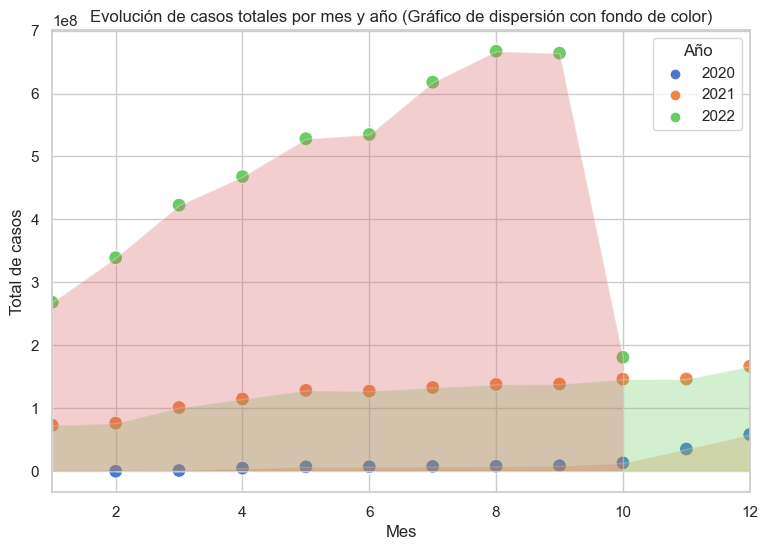

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")
sns.set_palette("muted")

dfT = pd.DataFrame(df['data'])
dfT['Año'] = df['data'].dt.year.astype(np.int64)
dfT['Mes'] = df['data'].dt.month.astype(np.int64)
dfT['Total de casos'] = df['totale_casi'].astype(np.float64)
dfT = pd.DataFrame(dfT.groupby(['Año','Mes'])['Total de casos'].sum())
dfT.reset_index(inplace=True)

plt.figure(figsize=(9, 6))
sns.scatterplot(data=dfT, x='Mes', y='Total de casos', hue='Año', palette='muted', s=100)

for year in dfT['Año'].unique():
    subset = dfT[dfT['Año'] == year]
    plt.fill_between(subset['Mes'], subset['Total de casos'], alpha=0.3)

plt.xlabel('Mes')
plt.ylabel('Total de casos')
plt.title('Evolución de casos totales por mes y año (Gráfico de dispersión con fondo de color)')
plt.legend(title='Año')
plt.xlim(1, 12)
plt.show()


# JointGrid de latitud y longitud por aparición siendo más oscuro con más apariciones

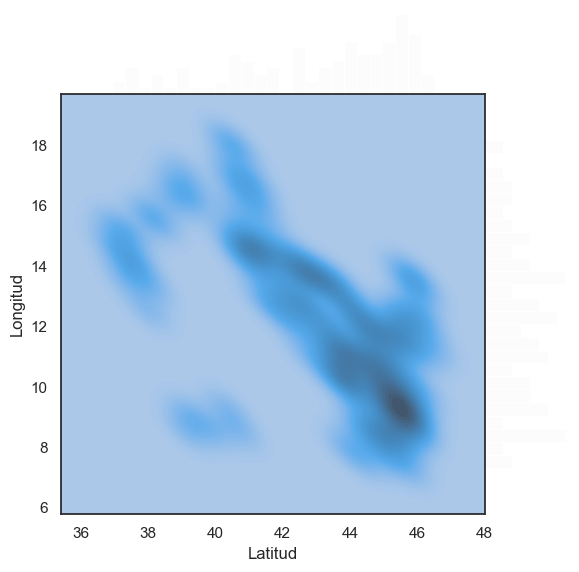

In [7]:
sns.set_theme(style="white")
sns.set_palette("pastel")

g = sns.JointGrid(data=df[:25000], x="lat", y="long", space=0)
g.plot_joint(sns.kdeplot, fill=True, thresh=0, levels=100)
g.plot_marginals(sns.histplot, color="#03051A", alpha=0.01, bins=25)

plt.subplots_adjust(top=0.95)

g.ax_joint.set_xlabel('Latitud')
g.ax_joint.set_ylabel('Longitud')

plt.show()


In [8]:
#!conda install -y conda-forge::basemap-data-hires
#!conda install -y conda-forge::basemap
#!conda install anaconda::libtiff 

# Mapa de Italia con la posición de cada registro por latitud y longitud

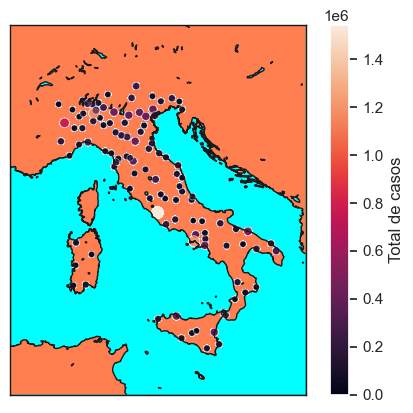

In [22]:
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="dark")
sns.set_palette("rocket")

m = Basemap(
    width=1200000, height=1500000,
    projection='lcc', resolution='h',
    lat_0=42, lon_0=12.5
)

fig, ax = plt.subplots()

df_plot = pd.DataFrame({'long': df['long'], 'lat': df['lat'], 'totale_casi': df['totale_casi']})

x, y = m(df_plot['long'].values, df_plot['lat'].values)

m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral', lake_color='aqua')

sc = sns.scatterplot(x=x, y=y,
                size=df_plot['totale_casi'],
                hue=df_plot['totale_casi'], palette='rocket', alpha=0.7,legend=False)

norm = plt.Normalize(df_plot['totale_casi'].min(), df_plot['totale_casi'].max())
sm = cm.ScalarMappable(cmap="rocket", norm=norm)

plt.colorbar(sm,ax=ax, label='Total de casos')

plt.show()


# Gráfico de regiones y evolución de casos

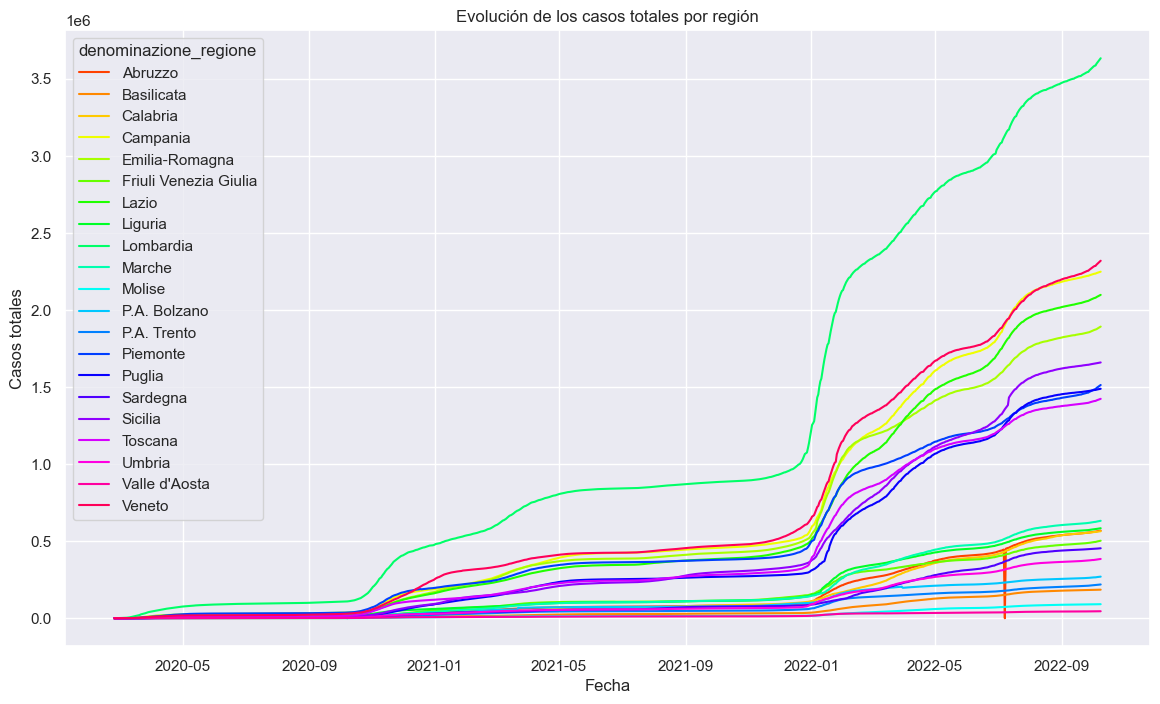

In [10]:
df_grouped = df.groupby(['denominazione_regione', 'data'])['totale_casi'].sum().reset_index()

sns.set_theme(style="darkgrid")
sns.set_palette("hsv")

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_grouped, x='data', y='totale_casi', hue='denominazione_regione',palette="hsv")
plt.title('Evolución de los casos totales por región')
plt.xlabel('Fecha')
plt.ylabel('Casos totales')
plt.show()